# ATAC-seq Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

In [158]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Functions

In [154]:

def get_matched_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
        
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]


    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Preprocessing

In [3]:
# file directories
workingDirectory = '/home/jenhan/analysis/atac_analysis/'

genomes = ['hg19','mm10', 'hg38']
scratchDirectory = workingDirectory + '/scratch/'


### RNA-seq

In [4]:

tagDirPath = workingDirectory + '/tag_directories_rna/'


os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['Cell Type'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

### ATAC-seq

In [5]:

tagDirPath = workingDirectory + '/tag_directories_atac/'

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), 
                                                  list(summary_frame['Cell Type'].values), 
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_atac.tsv', sep='\t', index=False)
summary_frame_atac = summary_frame.copy()

## Filter Data on QC Metrics

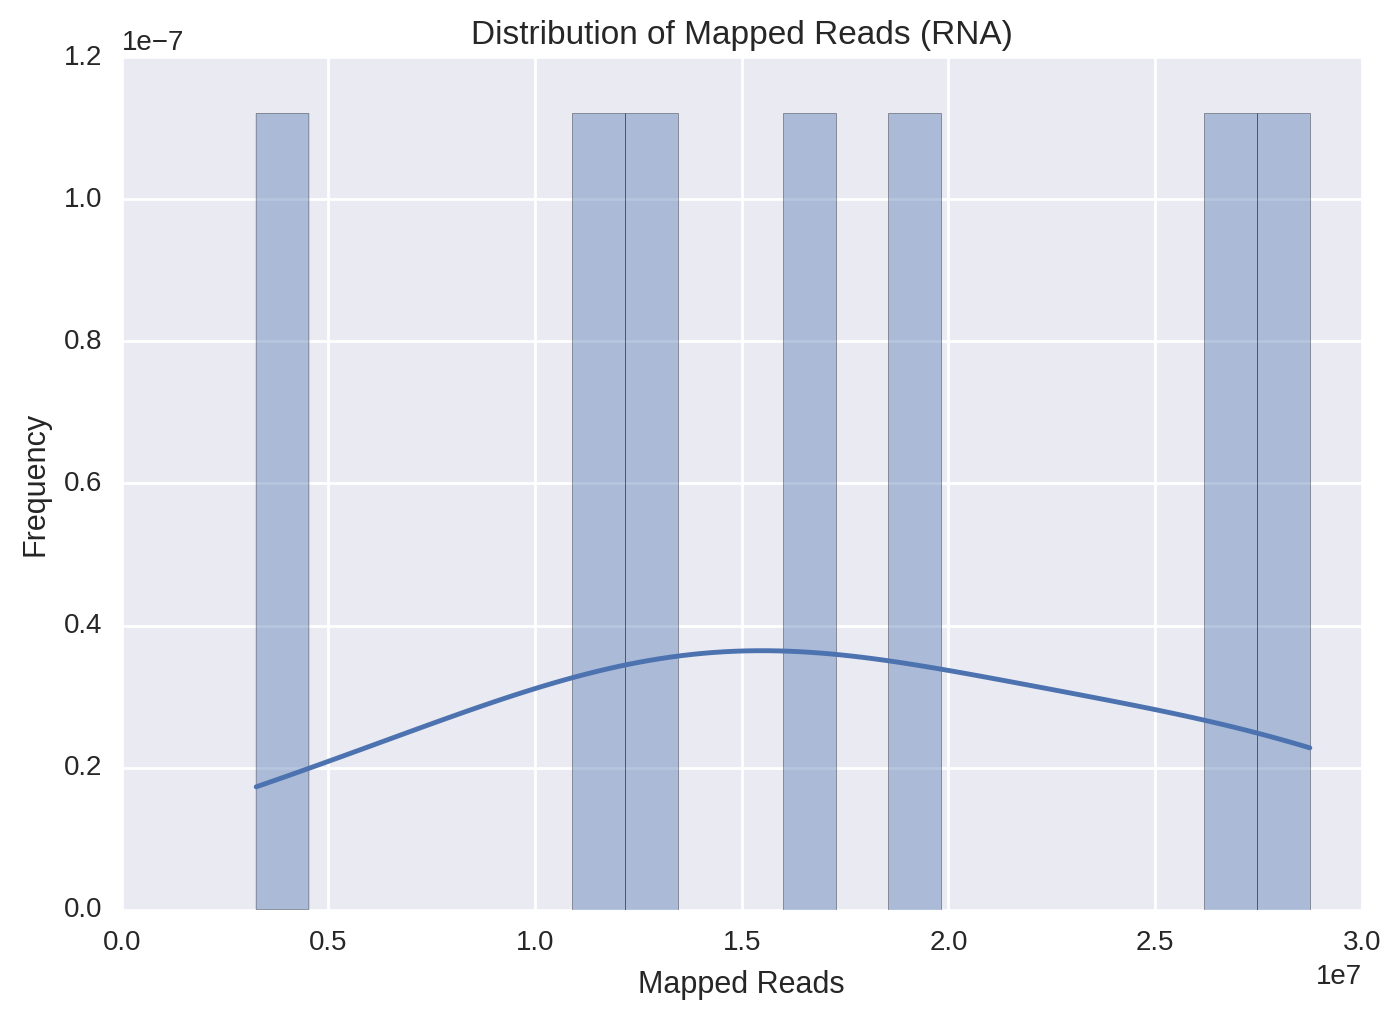

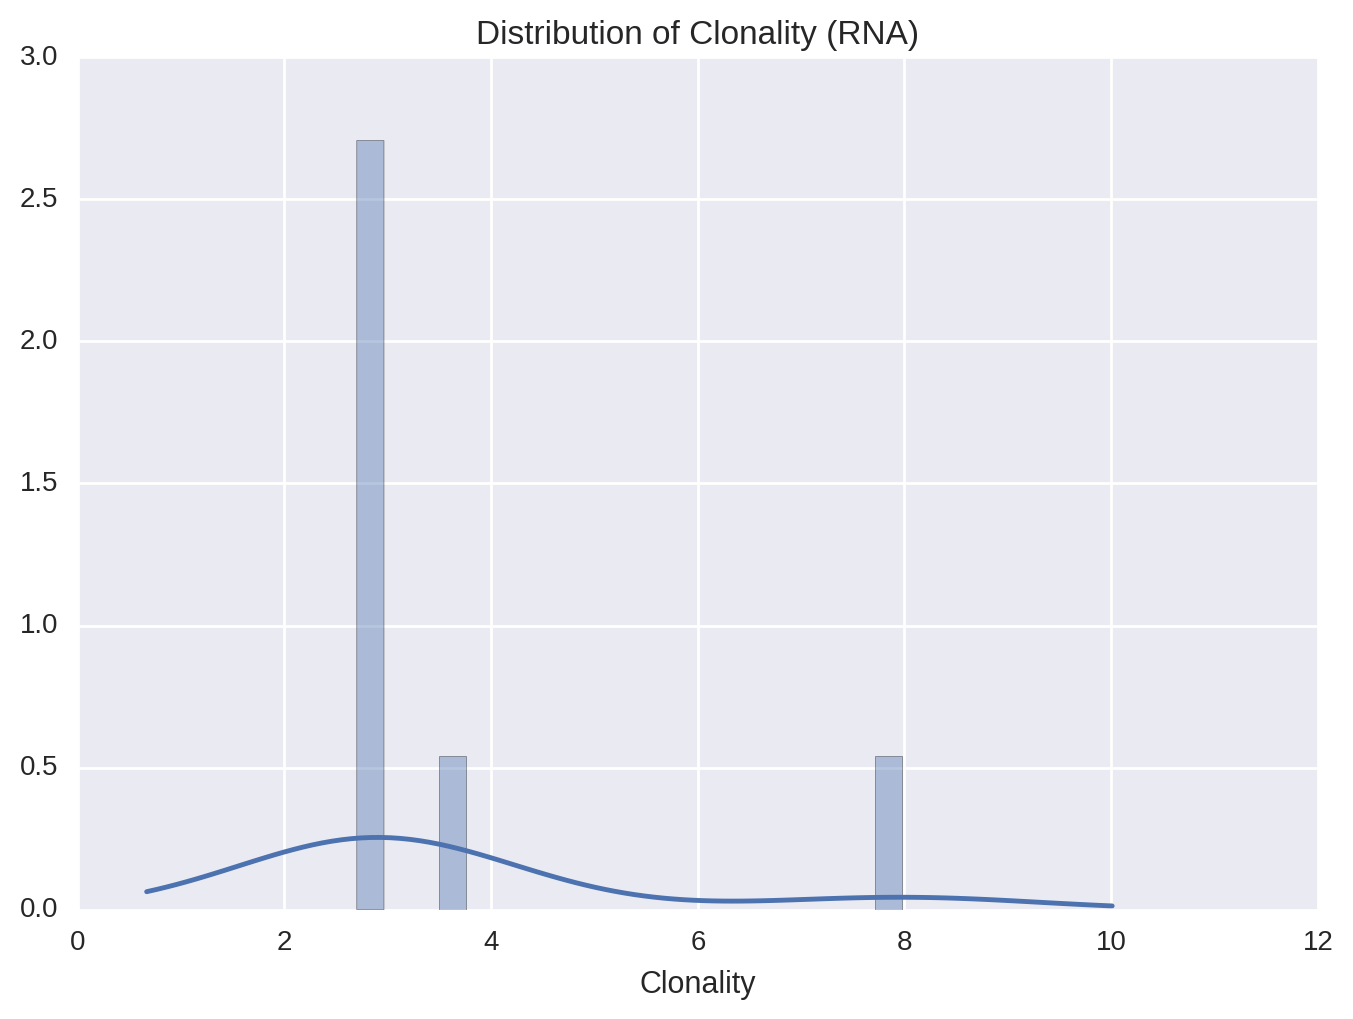

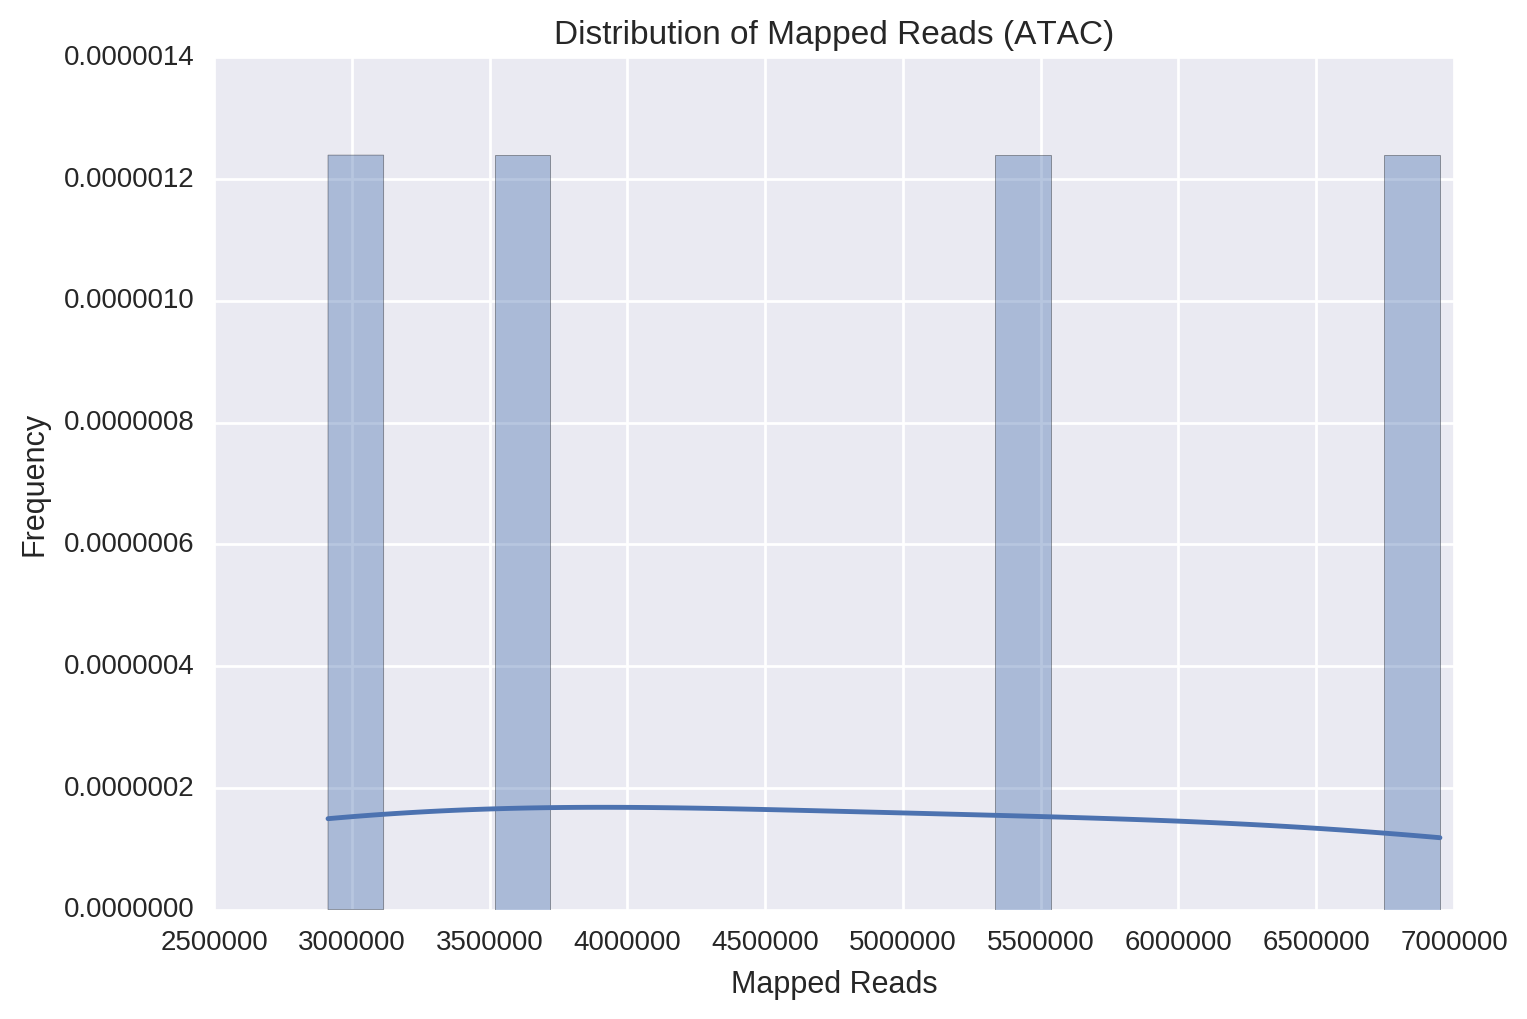

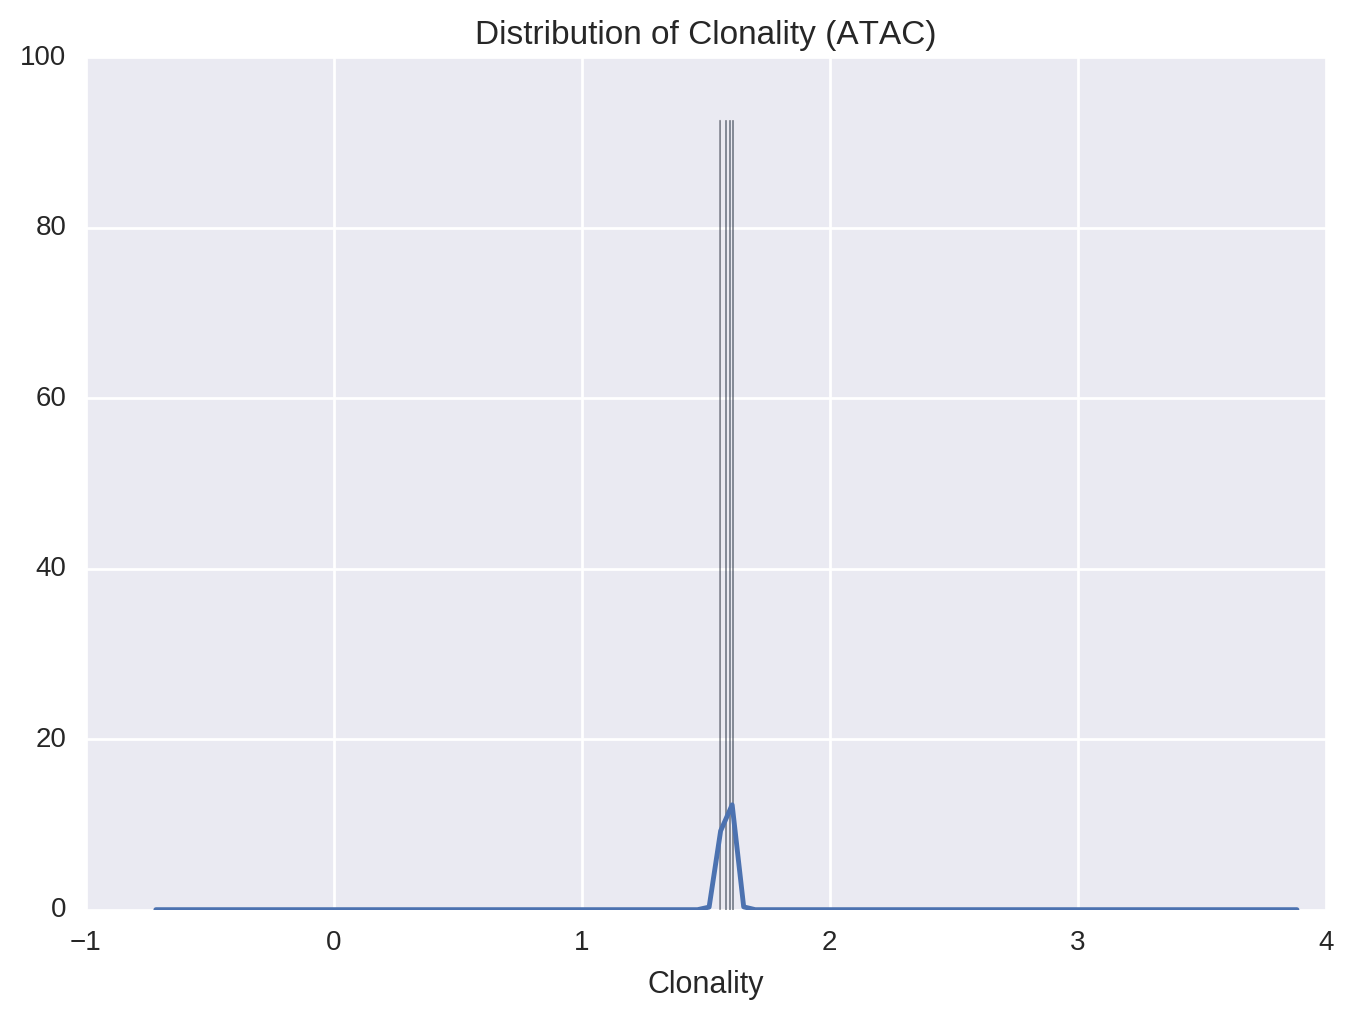

In [6]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame_atac['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (ATAC)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_atac['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (ATAC)')
plt.xlabel('Clonality')
plt.show()


In [7]:
filtered_summary_frame_atac = summary_frame_atac.copy()

In [8]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 1000000
pbcThreshold=0.0
# gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]

## Calculate RPKM Values

In [9]:
filteredTagDirectories = ' '.join(['/home/jenhan/analysis/atac_analysis//tag_directories_rna/' +x for x in filtered_summary_frame_rna['sampleName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv



	Tag Directories:
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_VML_15-02-26
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_14-12-15
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_CR_12-03-09
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_15-04-06
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_CR_12-03-09
		/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_GFEW_16-02-04
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26
	Calculating read coverage for /home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_T

In [10]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]


raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

### Run IDR

In [14]:
# %%capture
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_rna/'
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['Cell Type'] +
                                             '_' + filtered_summary_frame_rna['treatment']))
originalName_strain_dict = dict(zip(filtered_summary_frame_rna['sampleName'], filtered_summary_frame_rna['strain']))

conditions = " ".join([originalName_strain_dict[x] + '_' + originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/atac_analysis/idr_rna/ C57Bl6_Thiomac_KLA C57Bl6_Thiomac_Veh C57Bl6_Thiomac_Veh C57Bl6_Thiomac_Veh C57Bl6_Thiomac_Veh C57Bl6_Thiomac_KLA C57Bl6_Thiomac_Veh &
Output files will be written to: /home/jenhan/analysis/atac_analysis/idr_rna/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26 FPKM 	 C57Bl6_Thiomac_KLA
/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_VML_15-02-26 FPKM 	 C57Bl6_Thiomac_Veh
/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_14-12-15 FPKM 	 C57Bl6_Thiomac_Veh
/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_CR_12-03-09 FPKM 	 C57Bl6_Thiomac_Veh
/home/jenhan/analysis/atac_analysis//tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_15-

In [15]:
idr_rpkm_frame = pd.read_csv('idr_rna/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = idr_rpkm_median_frame.sort()

idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame.to_pickle('idr_rpkm_median_frame.pickle')

In [16]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['strain'] 
                                 + '_'+ filtered_summary_frame_rna['Cell Type']
                                 + '_'+ filtered_summary_frame_rna['treatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x.split('/')[-1]] for x in samples])
! getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats C57Bl6_Thiomac_KLA vs. C57Bl6_Thiomac_Veh:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_Thiomac_Veh vs. C57Bl6_Thiomac_KLA: 10 (0.041%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_Thiomac_Veh vs. C57Bl6_Thiomac_KLA: 206 (0.842%) [log2fold<-1, FDR<0.05]



In [17]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

## ATAC-seq Peak Calling

In [12]:
### call peaks ###
peakDirectory = '/home/jenhan/analysis/atac_analysis/peak_files'
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names

for sn in filtered_summary_frame_atac['sampleName'].values:
    
    peakFileName = sn + "_peaks.tsv"

    print('findPeaks ' + tagDirPath + '/' + sn + 
                     ' -L 0 -C 0 -fdr 0.9' +
                     ' -style factor -size 100  > ' + 
                     peakDirectory +'/' + peakFileName + ' &')



findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 100  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 100  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 100  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 100  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATA

### Run IDR

In [13]:
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame_atac.index):
    factor_treatment_rows = filtered_summary_frame_atac.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame_atac.ix[ri, 'sampleName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            !echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            

python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &


In [18]:
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'
count_dict = {}
for f in os.listdir(idrDirectory):
    if 'idr.tsv' in f:
        tokens = f.split('_')
        strain = tokens[0]
        cellType = tokens[1]
        treatment = tokens[3].split('-')[0]
        condition = '_'.join([strain, cellType, treatment])
        with open(idrDirectory + f) as file:
            data = file.readlines()
        numPeaks = len(data) - 1
        if not condition in count_dict:
            count_dict[condition] = (f, numPeaks)
        else:
            if numPeaks > count_dict[condition][1]:
                count_dict[condition] = (f, numPeaks)        
for key in count_dict:
    idrResult = count_dict[key][0]
    peakFileName = key+'_peaks.tsv'

    !echo cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName
    !cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName

cp /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.tsv ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv
cp /home/jenhan/analysis/atac_analysis/idr_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks_C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks_idr.tsv ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv


### Create background peaks from genomic sequences

In [36]:
with open('./mm10_genome/chr19.fa') as f:
    data=f.readlines()

In [61]:
genome_seq = ''
for line in data[1:]:
    genome_seq += line.strip().upper()
genome_seq_size = len(genome_seq)

In [67]:
is_N = [True if x == 'N' else False for x in genome_seq]
is_A = [True if x == 'A' else False for x in genome_seq]
is_C = [True if x == 'C' else False for x in genome_seq]
is_G = [True if x == 'G' else False for x in genome_seq]
is_GC = [True if x == 'G' or x == 'C' else False for x in genome_seq]
is_T = [True if x == 'T' else False for x in genome_seq]
is_peak = [False for x in genome_seq]


In [79]:
# create peak files that contain peaks from a given chromosome
! if [ ! -d ./genome_tile_peak_files ]; then mkdir ./genome_tile_peak_files; fi

for f in os.listdir('./idr_peak_files/'):
    if '_peaks.tsv' in f:
        with open('./idr_peak_files/'+f) as file:
            data = file.readlines()
        chrom_peak_file = open('./genome_tile_peak_files/'+f,'w')
        for line in data:
            if line[0] == '#':
                chrom_peak_file.write(line)
            elif chromosome in line:
                tokens = line.split('\t')
                start = int(tokens[2]) -1
                end = int(tokens[3])
                for i in range(start, end):
                    is_peak[i] = True
                chrom_peak_file.write(line)
        chrom_peak_file.close()

In [66]:
! if [ ! -d ./genome_tiles ]; then mkdir ./genome_tiles; fi

In [93]:
# create two sets of tiled sequences
# - - - - - set 1
#  - - - -  set 2

# create first set of tile sequences
peakSize = 100
chromosome = 'chr19'
N_threshold = 0.5
tileSet1 = open('./genome_tiles/tileSet1_peaks.tsv', 'w')
tileSet1.write('\t'.join(['#PeakID', 'chr', 'start', 'end', 'strand','score','\n']))
counts = []
for i in range(0,genome_seq_size, peakSize):
    
    n_count = np.sum(is_N[i:i+peakSize+1])
    counts.append(n_count)
    if not n_count > peakSize * N_threshold:
        if not np.sum(is_peak[i:i+peakSize+1]) > 0:
            tileSet1.write('\t'.join(['tileSet1_'+str(i), chromosome, str(i), str(i+peakSize), '+','-1','\n']))

tileSet1.close()
    

In [94]:
# create second set of tile sequences
tileSet2 = open('./genome_tiles/tileSet2_peaks.tsv', 'w')
tileSet2.write('\t'.join(['#PeakID', 'chr', 'start', 'end', 'strand','score','\n']))
counts = []
for i in range(int(0+peakSize/2),genome_seq_size, peakSize-int(peakSize/2)):
    
    n_count = np.sum(is_N[i:i+peakSize+1])
    counts.append(n_count)
    if not n_count > peakSize * N_threshold:
        if not np.sum(is_peak[i:i+peakSize+1]) > 0:
            tileSet2.write('\t'.join(['tileSet2_'+str(i), chromosome, str(i), str(i+peakSize), '+','-1','\n']))

tileSet2.close()

### Merge peak Files

In [128]:
# ! mergePeaks -d given -venn venn.txt ./idr_peak_files/* > ./merged_peaks.tsv
# ! makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./idr_peak_files/*
! mergePeaks -d given -venn venn.txt ./genome_tile_peak_files/* > ./merged_peaks.tsv
! makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./idr_peak_files/*


	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./genome_tile_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (1380 total) and ./genome_tile_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (1380 total)
	Comparing ./genome_tile_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (1380 total) and ./genome_tile_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (529 total)
	Comparing ./genome_tile_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (529 total) and ./genome_tile_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (1380 total)
	Comparing ./genome_tile_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (529 total) and ./genome_tile_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (529 total)

Finished reading merged peak file...
Integrating scores for C57Bl6_Thiomac_KLA
Integrating scores for C57Bl6_Thiomac_Veh


In [129]:
merged_frame = pd.read_csv('merged_peaks.tsv',sep='\t')
factors = [','.join([x.split('/')[-1].replace('_peaks.tsv','') for x in y.split('|')]) for y in merged_frame['Parent files'].values]
merged_frame = merged_frame.ix[:,:6]
columns = merged_frame.columns.values
columns[0] = '#PeakID'
columns[-1] = 'score'
merged_frame.columns = columns

tile_frame_1 = pd.read_csv('./genome_tiles/tileSet1_peaks.tsv',sep='\t')
tile_frame_1 = tile_frame_1.ix[:,:6]

merged_frame = pd.concat([merged_frame, tile_frame_1])

merged_frame.to_csv('merged_tile_peaks.tsv', sep='\t', index=False)
factors += ['tileSet1'] * tile_frame_1.shape[0]
merged_frame['Factors'] = factors
merged_frame = merged_frame[['#PeakID','Factors', 'chr', 'start','end', 'score']]
merged_frame.index = merged_frame['#PeakID'].values

In [20]:
!annotatePeaks.pl ./merged_tile_peaks.tsv mm10 > merged_annotated_peaks.tsv




	Peak file = ./merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50812
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 50812
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	385.0	19685193	0.067
		miRNA	1.0	20053	1.417
		ncRNA	125.0	2894170	1.210
		TTS	587.0	26244990	0.261
		pseudo	7.0	519312	-0.470
		Exon	669.0	33304595	0.106
		Intron	19995.0	928729349	0.206
		Intergenic	17190.0	1679735519	-0.867
		Promoter	11389.0	28426127	4.424
		5UTR	448.0	2090690	3.521
		snoRNA	1.0	19	11.461
		rRNA	13.0	5631	6.950
	NOTE: If t

## Scan Peaks for Motifs

In [132]:
%%bash
if [ ! -d ./group ]; then mkdir ./group; fi
cp merged_tile_peaks.tsv ./group
/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh ./group/ ./group 0

python extendPeaks.py ./group//merged_tile_peaks.tsv ./group//merged_tile_extPeaks.tsv 0
homerTools extract ./group//merged_tile_extPeaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > ./group/merged_tile.fa



	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 580146 sequences from chr19


In [134]:
### read in sequences as dictionary {peakID: sequence}
with open('./group/merged_tile.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()

In [135]:
# create a script to scan for motifs using FIMO
! if [ ! -d ./fimo_out/ ]; then mkdir ./fimo_out/; fi
! if [ ! -d ./fimo_results/ ]; then mkdir ./fimo_results/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = './fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' ./group/merged_tile.fa '+
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()




In [24]:
%%bash
chmod a+x ./scanMotifs.sh
./scanMotifs.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using background frequencies from NR sequence database.
Read 1 motifs.
Read 1 motifs.
Using motif +thap1 of width 9.
Using motif -thap1 of width 9.
Using motif +yy2 of width 11.
Using motif -yy2 of width 11.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using back

## Read in Score Files

### From Pickles

In [ ]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
peak_frame = pd.read_pickle('peak_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))

      
### work with just intergenic peaks for now ###
# intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
# motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
# motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
# motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
# motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
# motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
# normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
# scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
# annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]


### read in sequences as dictionary {peakID: sequence}
with open('./group/merged_tile.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()   
        
        
        
idr_rpkm_frame = pd.read_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame = pd.read_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame = pd.read_pickle('idr_rpkm_median_frame.pickle')

### Peak Scores

In [177]:
# read in peak data data
# peak_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
# peak_frame = peak_frame.fillna('0')
# for col in peak_frame.columns[5:]:
#     floatValues = []
#     for val in peak_frame[col].values.astype(str):
#         if ',' in val:
#             maxVal = np.max([float(x) for x in val.split(',')])
#             floatValues.append(maxVal)
#         else:
#             floatValues.append(float(val))
#     peak_frame[col] = floatValues
# peak_frame.index = peak_frame['ID'].values

# # remove peaks in unknown/random chromosomes
# peak_frame = peak_frame[~peak_frame['chr'].str.contains('random')]
# peak_frame = peak_frame[~peak_frame['chr'].str.contains('Un')]

peak_frame = merged_frame
columns = peak_frame.columns.values
columns[0] = 'ID'
peak_frame.columns = columns
_factors = sorted(list(set([x.split('_')[1] for x in peak_frame.columns if '_' in x])))
peak_frame.to_pickle('peak_frame.pickle')



In [141]:
annotation_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
columns = annotation_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
annotation_frame.columns = columns


### Motif Scores

In [199]:
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

peak_start_dict = dict(zip(peak_frame['ID'].values, peak_frame['start'].values))

motif_score_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_score_frame.index=motif_score_frame['ID'].values

motif_sequence_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_sequence_frame.index=motif_score_frame['ID'].values

motif_strand_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_strand_frame.index=motif_score_frame['ID'].values

motif_start_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_start_frame.index=motif_score_frame['ID'].values

motif_end_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_end_frame.index=motif_score_frame['ID'].values

motif_count_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_count_frame.index = motif_count_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results//merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        id_strand_dict = {}
        id_sequence_dict = {}
        id_start_dict = {}
        id_end_dict = {}
        id_count_dict = {}
        
        ids = fimo_result_frame['peak_id'].values
        scores = fimo_result_frame['score'].values
        strands = fimo_result_frame['strand'].values
        sequences = fimo_result_frame['sequence']
        starts = fimo_result_frame['start']
        ends = fimo_result_frame['stop']
        
        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])
            if currentScore < 0.0:
                currentScore = 0.0
            if ids[i] in id_score_dict:
                if currentScore > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] += 1
            else:
                id_score_dict[ids[i]] = currentScore
                id_sequence_dict[ids[i]] = currentSequence
                id_strand_dict[ids[i]] = currentStrand
                id_start_dict[ids[i]] = currentStart
                id_end_dict[ids[i]] = currentEnd
                id_count_dict[ids[i]] = 0
                
        motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
        motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
        motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
        motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
        motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
        motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]
        
motif_score_frame.to_pickle('motif_score_frame.pickle')
motif_score_frame.to_csv('motif_scores.tsv', sep='\t', index=False)

motif_sequence_frame.to_pickle('motif_sequence_frame.pickle')
motif_sequence_frame.to_csv('motif_sequence.tsv', sep='\t', index=False)

motif_strand_frame.to_pickle('motif_strand_frame.pickle')
motif_strand_frame.to_csv('motif_strand.tsv', sep='\t', index=False)

motif_start_frame.to_pickle('motif_start_frame.pickle')
motif_start_frame.to_csv('motif_start_frame.tsv', sep='\t', index=False)

motif_end_frame.to_pickle('motif_end_frame.pickle')
motif_end_frame.to_csv('motif_end_frame.tsv', sep='\t', index=False)

motif_count_frame.to_pickle('motif_count_frame.pickle')
motif_count_frame.to_csv('motif_count_frame.tsv', sep='\t', index=False)

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

1 alx1_alx4_arx.fimo
2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fim

In [ ]:

### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
peak_frame = peak_frame[peak_frame.index.isin(intergenic_ids)]
annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



## Actual Analysis?..

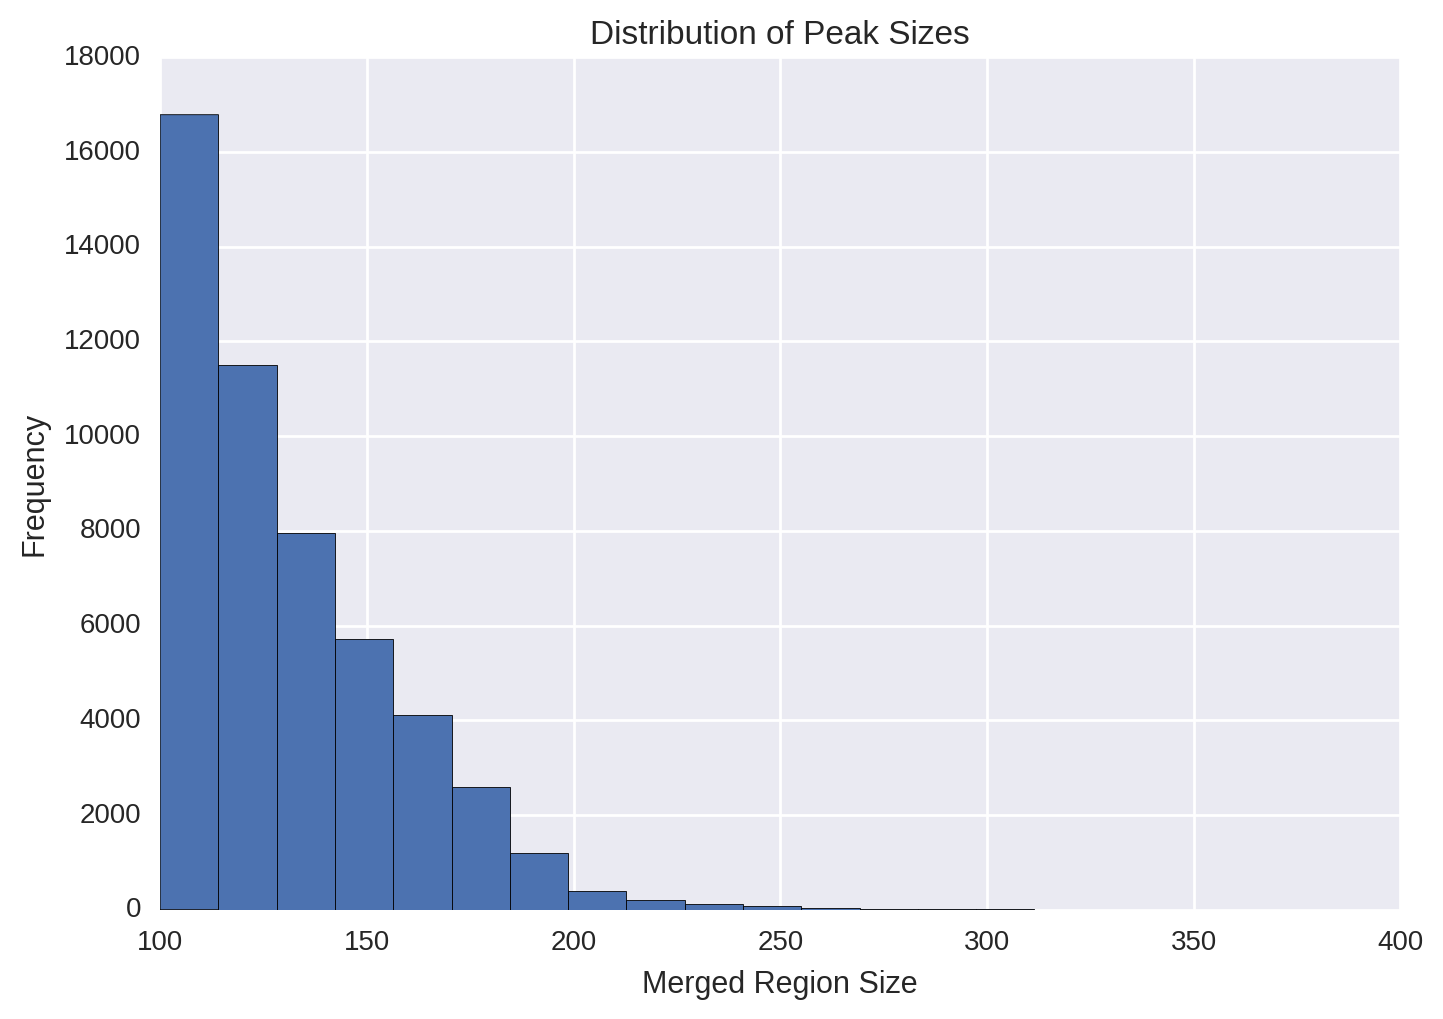

In [190]:

# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

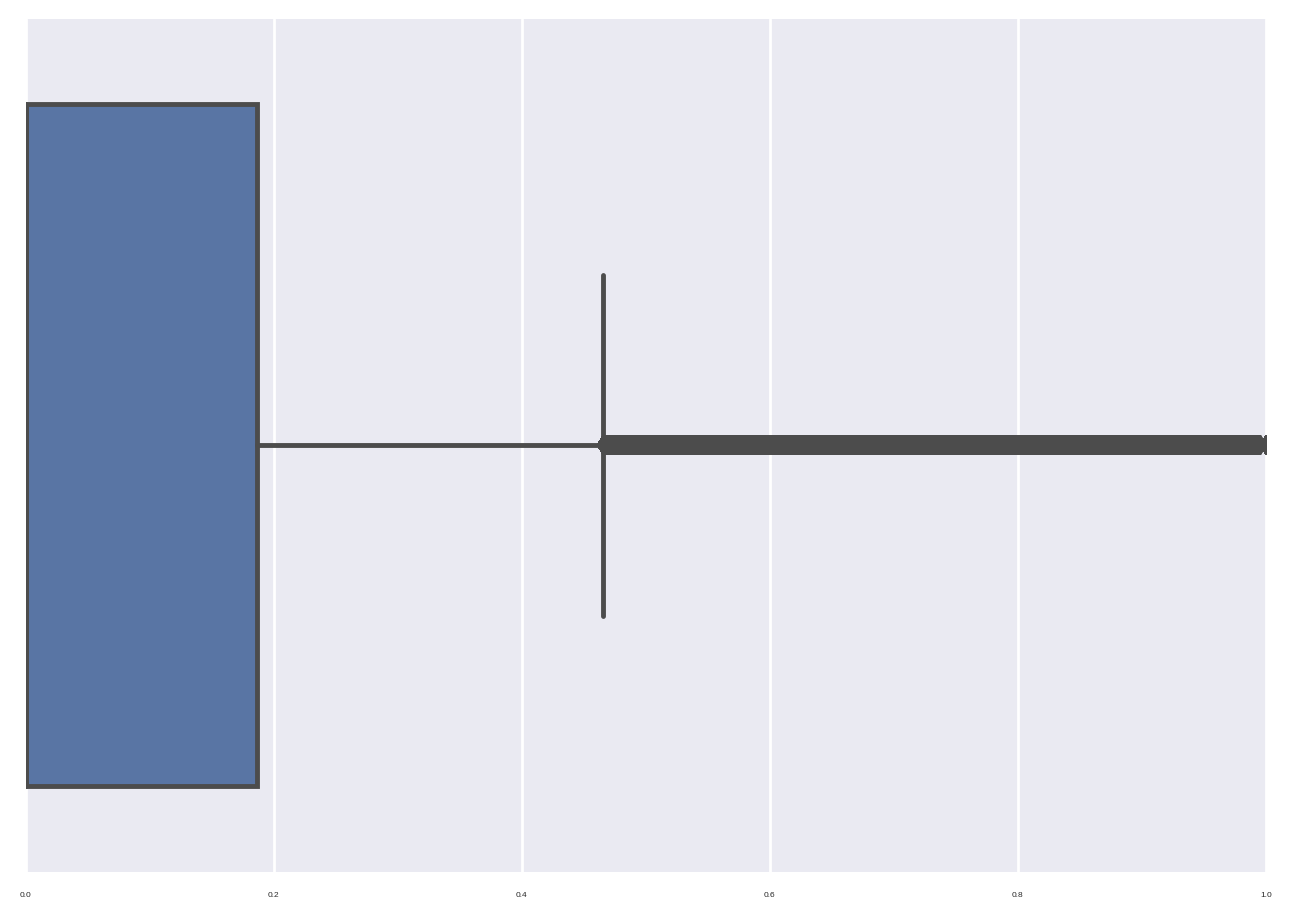

In [200]:
sns.boxplot(normed_motif_frame.ix[:,3:].values.flatten())

In [ ]:
# plot distribution of motif scores
sns.set_context('notebook', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in motif_score_frame.columns[3:]:
    data_dict[col] = motif_score_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.show()
del data_dict
sns.set_context('talk', font_scale=1.0)

# plot distribution of normed motif scores
sns.set_context('notebook', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in normed_motif_frame.columns:
    data_dict[col] = normed_motif_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
del data_dict
plt.show()
sns.set_context('notebook', font_scale=1.0)

sns.distplot(motif_score_frame.ix[:,3:].values.flatten())
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('Motif Score')
plt.ylabel('Frequency')
plt.show()
sns.distplot(normed_motif_frame.ix[:,3:].values.flatten())
# plt.xlim(-0.05, 0.05)
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('NormalizedMotif Score')
plt.ylabel('Frequency')

In [ ]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = motif_score_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = motif_score_frame[motif1].values
        motifScores2 = motif_score_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho
        motif_corr_pearson_matrix[j][i] = r
        motif_corr_spearman_matrix[j][i] = rho


# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Spearman Correlation')
plt.show()

In [ ]:
sns.distplot(motif_corr_pearson_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Pearson Correlations')
plt.show()
sns.distplot(motif_corr_spearman_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Spearman Correlations')

In [187]:
np.sum(labels)

529

In [215]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
factors = ['C57Bl6_Thiomac_Veh']
for factor in factors:
    features = normed_motif_frame
    labels = peak_frame['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_matched_split(
        features, labels, test_size = 0.2)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame = pd.DataFrame(factor_coeff_dict)
coefficients_frame = coefficients_frame[factors]
coefficients_frame.index = normed_motif_frame.columns.values


C57Bl6_Thiomac_Veh 0.986795605265


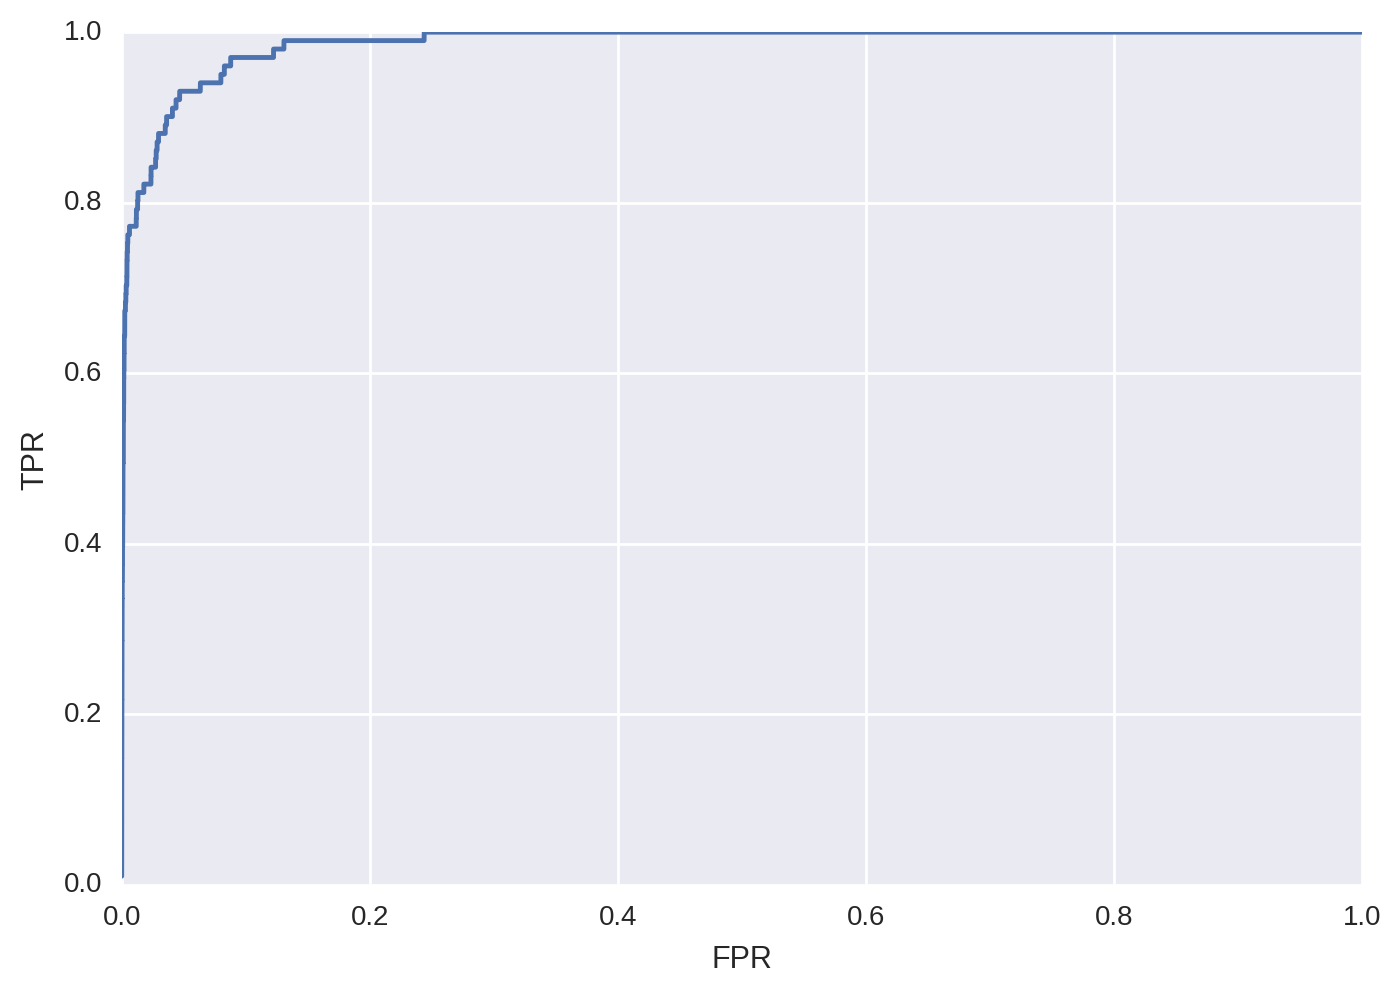

In [216]:
sns.set_context('notebook', font_scale=1.0)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [217]:
factor_auc_dict_all

{'C57Bl6_Thiomac_Veh': 0.9867956052650525}

In [218]:
factor_coeff_dict

{'C57Bl6_Thiomac_Veh': array([  0.00000000e+00,   2.23044880e+00,   0.00000000e+00,
         -8.75573688e-01,  -7.07758949e-02,   1.24121180e-01,
          0.00000000e+00,   3.91654311e-01,   1.42520924e+00,
          6.93584660e-01,   1.08563579e+00,   0.00000000e+00,
          2.34395573e-01,  -2.80927521e-01,   0.00000000e+00,
          0.00000000e+00,   2.19527881e+00,   2.27015900e+00,
          1.38168147e-01,   0.00000000e+00,   3.20956567e+00,
          9.37612509e-01,   3.60596287e-01,   7.83182988e-01,
          9.37522148e-01,  -3.82167484e-01,   0.00000000e+00,
          4.10297892e-01,   1.92551276e+00,   0.00000000e+00,
          9.40810290e-01,   0.00000000e+00,   5.21221734e-01,
          1.13909052e-01,   0.00000000e+00,   1.00194147e+00,
          1.21919145e+00,   1.74814057e+00,   0.00000000e+00,
          6.43381954e-01,  -3.02593091e-01,   0.00000000e+00,
          0.00000000e+00,   2.46109958e-01,   1.16614680e-01,
          1.08941543e-01,   0.00000000e+00,   1.

In [219]:
threshold = 2.0
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame.columns.values:
    weights = coefficients_frame[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs.add(m)

        

C57Bl6_Thiomac_Veh -1.07468977693 2.03528619047


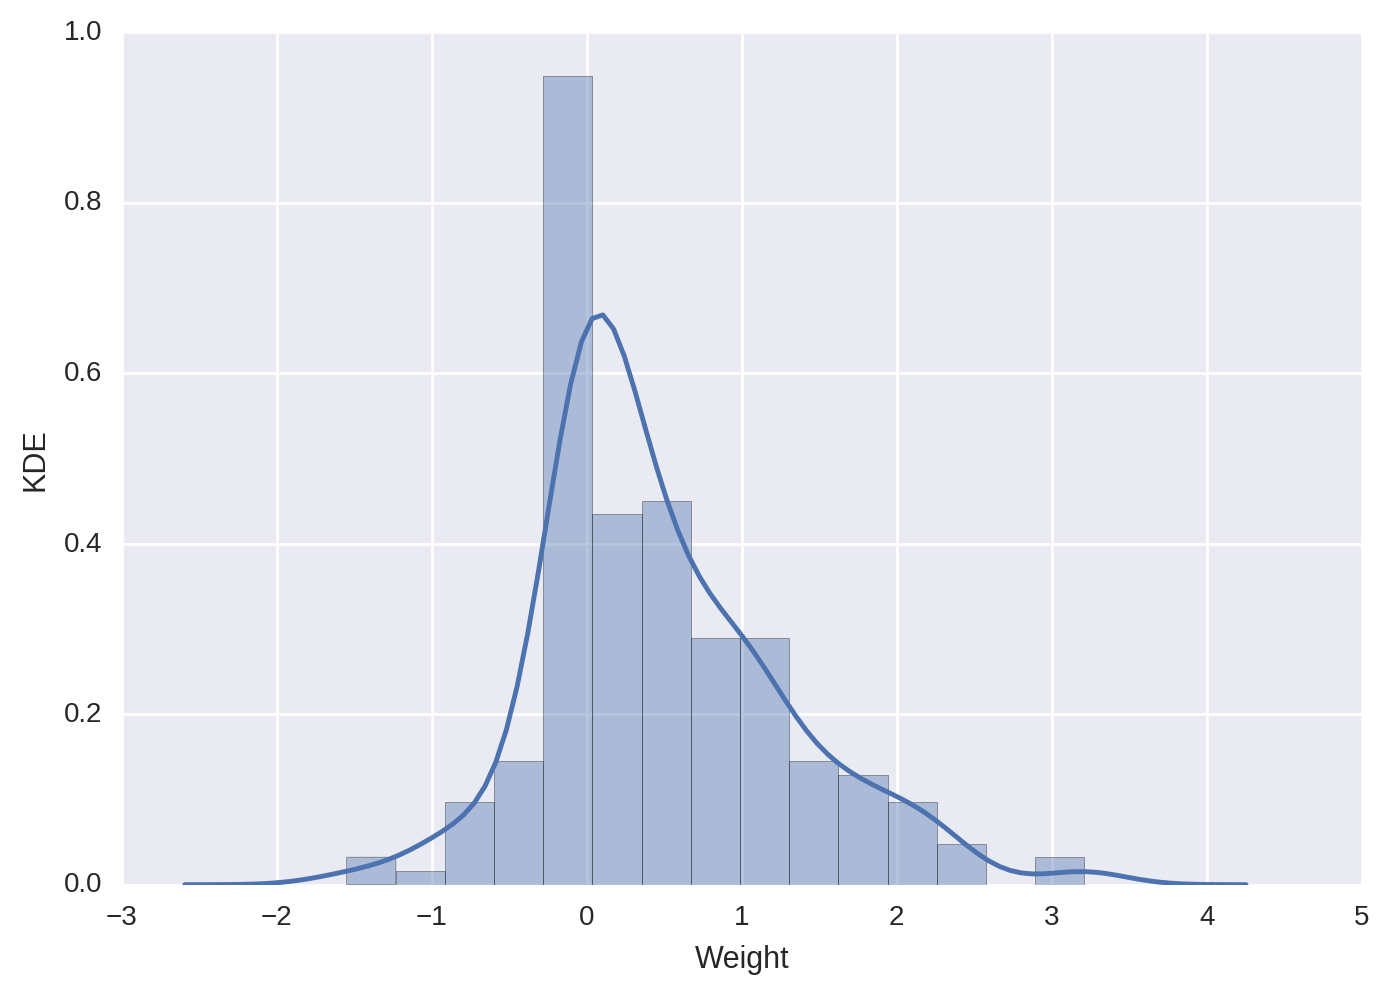

In [220]:
sns.distplot(coefficients_frame.values.flatten())
plt.ylabel('KDE')
plt.xlabel('Weight')

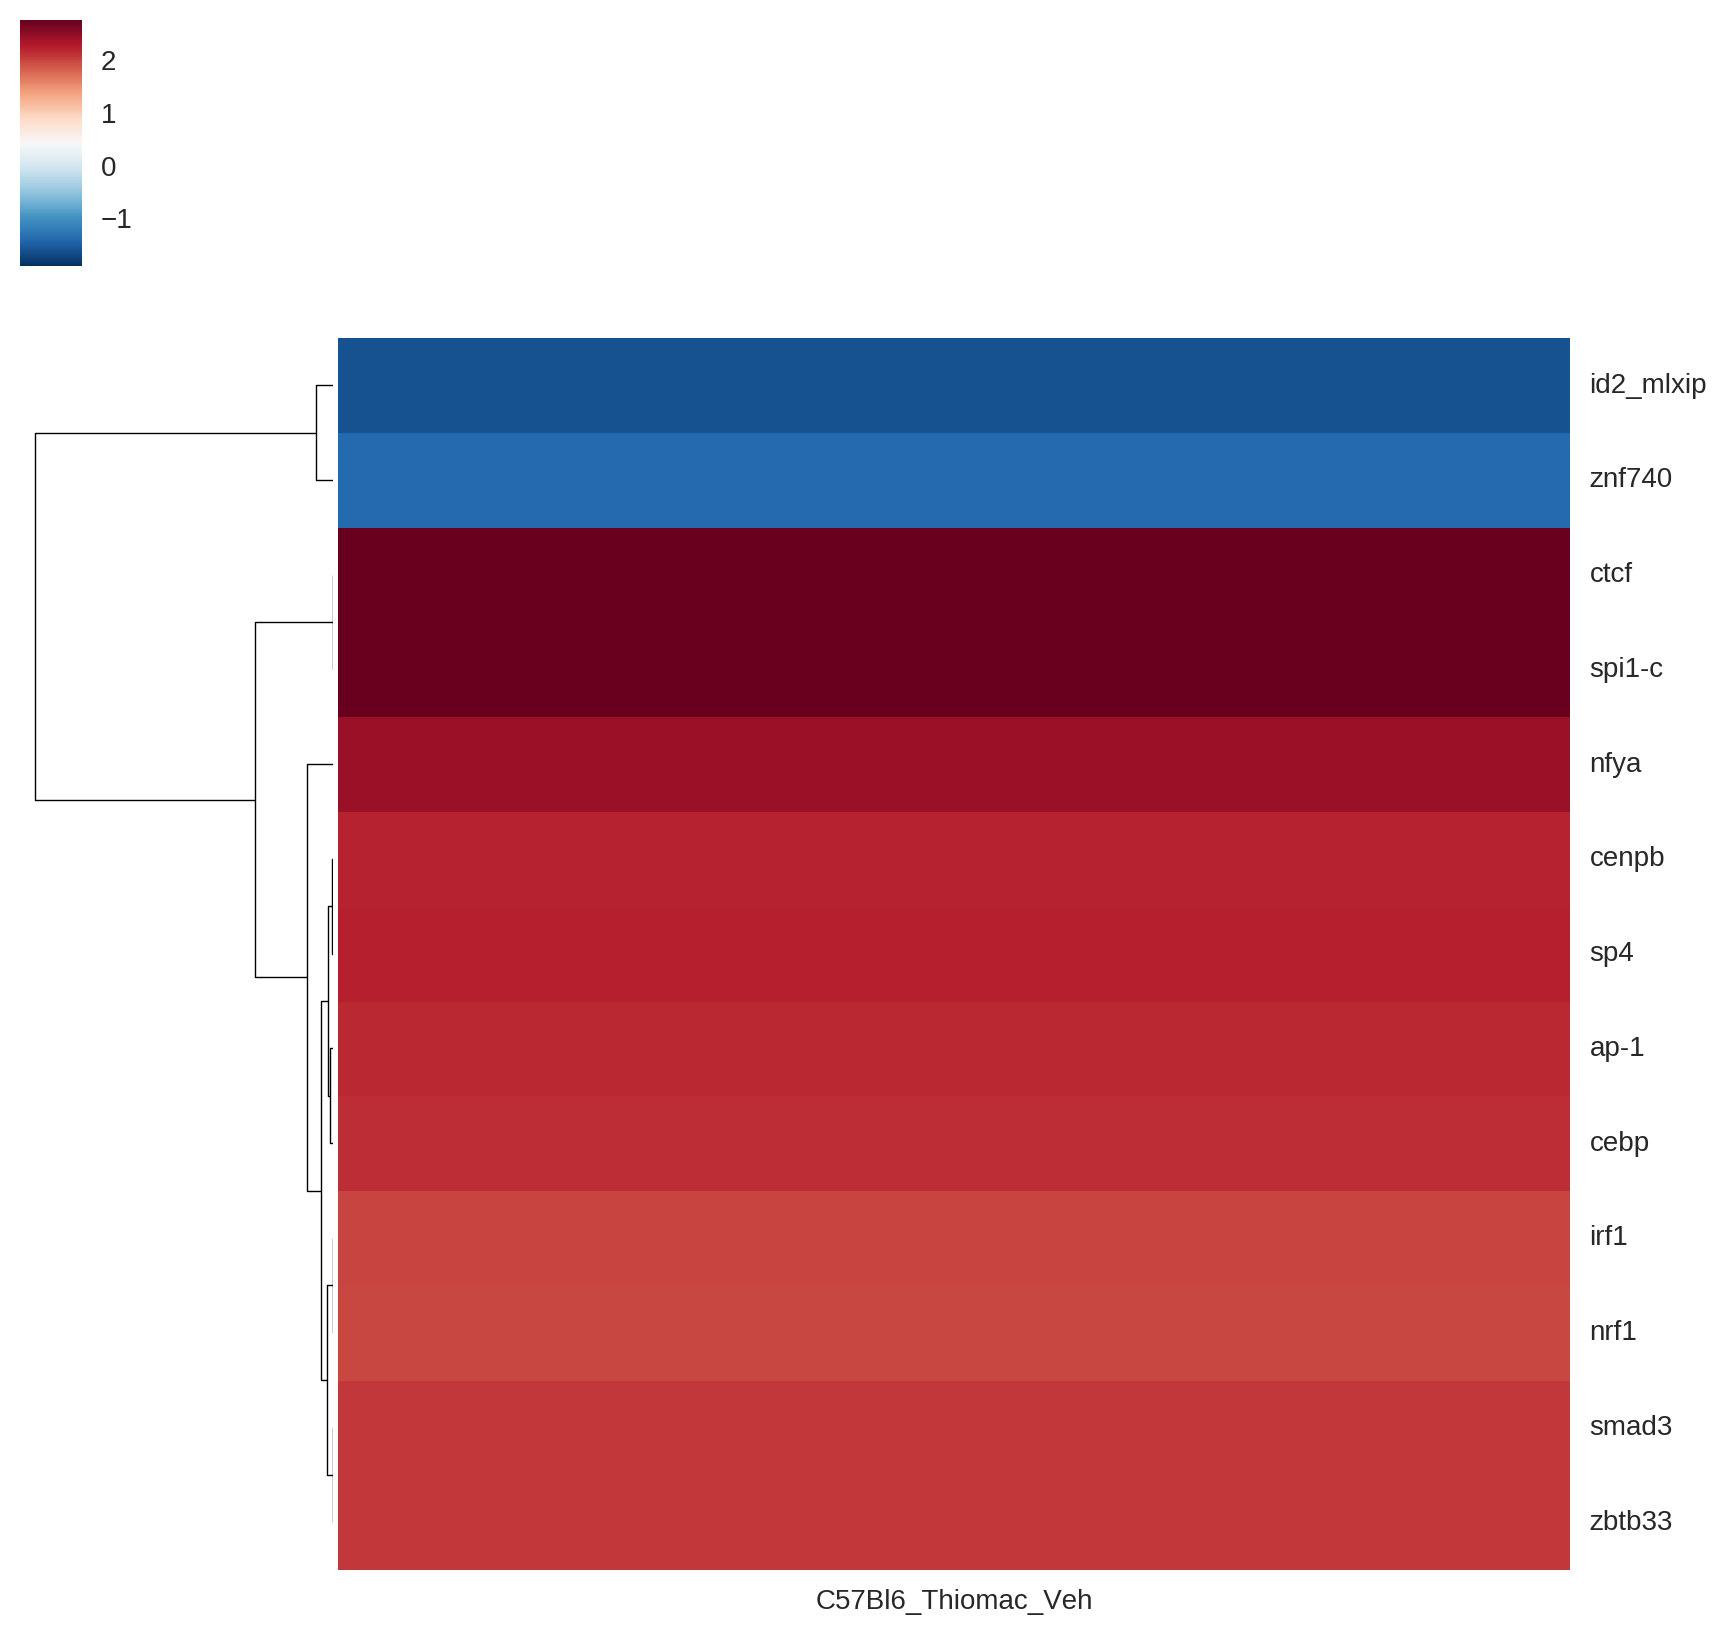

In [221]:
threshold = 3
coeff_std = np.std(coefficients_frame.values.flatten())
coeff_mean = np.mean(coefficients_frame.values.flatten())
data = coefficients_frame[coefficients_frame.index.isin(significant_motifs)]

# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},
                       col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);